In [1]:
import os
import astropy.io.fits as fits
import numpy as np
import scipy
import scipy.ndimage as ndi
import matplotlib.pylab as plt
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pyklip.klip
import pyklip.fakes as fakes
import pyklip.fm as fm
import pyklip.instruments.Instrument as Instrument
import pyklip.fmlib.fmpsf as fmpsf
import pyklip.fitpsf as fitpsf
from tqdm import tqdm
import sys

In [2]:
# for filtername in filternames:  
#     if filtername in ['f182m','f210m']:
#         print('Yay')

#     else:
#         print('No')

In [3]:
print(50-38)
print(90-50)

12
40


In [4]:
print(50-44)
print(70-50)

6
20


In [5]:
flux_vals = []
flux_err = []
filternames = ['f210m','f300m', 'f335m', 'f360m', 'f410m']
coronas = ['MASK210R.csv', 'MASK210R.csv', 'MASK335R.csv', 'MASK335R.csv', 'MASK430R.csv']
burn_ins = [200,200,400, 200,200]
guess_dxs = [12, 6, 6, 6 , 6]
guess_dys = [40, 20, 20, 20, 20]


In [6]:
for filtername, coronag, burn_in, guess_dx, guess_dy in zip(filternames, coronas, burn_ins, guess_dxs, guess_dys):
    data_folder = 'old_simulated_data/'

    # read in roll 1
    with fits.open(data_folder+"NIRCam_target_Roll1_{0}.fits".format(filtername)) as hdulist:
        roll1_cube = hdulist[0].data

    # read in roll 2
    with fits.open(data_folder+"NIRCam_target_Roll2_{0}.fits".format(filtername)) as hdulist:
        roll2_cube = hdulist[0].data   

    # read in ref star
    with fits.open(data_folder+"NIRCam_refs_SGD_{0}.fits".format(filtername)) as hdulist:
        ref_cube = hdulist[0].data 

    # read in unocculted PSF
    with fits.open(data_folder+"NIRCam_unocculted_{0}.fits".format(filtername)) as hdulist:
        psf_cube = hdulist[0].data 

    # combine the two rows
    full_seq = np.concatenate([roll1_cube, roll2_cube], axis=0)

    # two rolls are offset 10 degrees, this is the right sign (trust me)
    pas = np.append([0 for _ in range(roll1_cube.shape[0])], [10 for _ in range(roll2_cube.shape[0])])

    # for each image, the (x,y) center where the star is is just the center of the image
    centers = np.array([np.array(frame.shape)/2. for frame in full_seq])

    # give it some names, just in case we want to refer to them
    filenames = np.append(["roll1_{0}".format(i) for i in range(roll1_cube.shape[0])],
                          ["roll2_{0}".format(i) for i in range(roll1_cube.shape[0])])

    # create the GenericData object. This will standardize the data for pyKLIP
    dataset = Instrument.GenericData(full_seq, centers, IWA=4, parangs=pas, filenames=filenames)
    dataset.flipx = False # get the right handedness of the data

    # collapse reference psf in time
    psf_frame = np.nanmean(psf_cube, axis=0)

    # find the centroid
    bestfit = fakes.gaussfit2d(psf_frame, 71, 30, searchrad=4, guessfwhm=2, guesspeak=1, refinefit=True)

    psf_xcen, psf_ycen = bestfit[2:4]

    # recenter PSF to that location
    x, y = np.meshgrid(np.arange(-20,20.1,1), np.arange(-20,20.1,1))
    x += psf_xcen
    y += psf_ycen

    psf_stamp = scipy.ndimage.map_coordinates(psf_frame, [y,x])

    # Read in the transmission profile csv
    corona = pd.read_csv(coronag, names = ["rad_dist", "trans"])

    # Create the throughput correction function
    def transmission_corrected(input_stamp, input_dx, input_dy):

        """
        Args:
            input_stamp (array): 2D array of the region surrounding the fake planet injection site
            input_dx (array): 2D array specifying the x distance of each stamp pixel from the center
            input_dy (array): 2D array specifying the y distance of each stamp pixel from the center

        Returns:
            output_stamp (array): 2D array of the throughput corrected planet injection site.
            """

        # Calculate the distance of each pixel in the input stamp from the center
        distance_from_center = np.sqrt((input_dx) ** 2 + (input_dy) ** 2)

        # Interpolate to find the transmission value for each pixel in the input stamp (we need to turn the columns into arrays so np.interp can accept them)
        distance = np.array(corona["rad_dist"])
        transmission = np.array(corona["trans"])

        # Calculate the distance in pixels
        if filtername in ['f182m','f210m']:
            distance_pix = corona['rad_dist']/0.031
        else:
            distance_pix = corona['rad_dist']/0.063

        trans_at_dist = np.interp(distance_from_center, distance_pix, transmission)

        # Reshape the interpolated array to have the same dimensions as the input stamp
        transmission_stamp = trans_at_dist.reshape(input_stamp.shape)

        # Make the throughput correction
        output_stamp = transmission_stamp * input_stamp

        return output_stamp


    # setup FM guesses
    numbasis = np.array([1, 3, 10]) # KL basis cutoffs you want to try
    guess_dx = guess_dx # in pxiels (positive is to the left)
    guess_dy = guess_dy # in pixels (positive is up)
    guesssep = np.sqrt(guess_dx**2 + guess_dy**2) # estimate of separation in pixels
    guesspa = np.degrees(np.arctan2(guess_dx, guess_dy)) # estimate of position angle, in degrees
    guessflux = 1e-4
     # estimated contrast
    guessspec = np.array([1]) # braodband, so don't need to guess spectrum

    # initialize the FM Planet PSF class
    fm_class = fmpsf.FMPlanetPSF(dataset.input.shape, numbasis, guesssep, guesspa, guessflux, np.array([psf_stamp]),
                                 np.unique(dataset.wvs), spectrallib_units="contrast", spectrallib=[guessspec], field_dependent_correction = None)



    # PSF subtraction parameters
    # You should change these to be suited to your data!
    outputdir = "./" # where to write the output files
    prefix = f"pyklipfm-{filtername}-ADI-k50m1" # fileprefix for the output fileshttp://localhost:8888/notebooks/jwst_trials/throughput_loop.ipynb#
    annulus_bounds = [[guesssep-20, guesssep+20]] # one annulus centered on the planet
    subsections = 1 # we are not breaking up the annulus
    padding = 0 # we are not padding our zones
    movement = 1 # basically, we want to use the other roll angle for ADI.

    # run KLIP-FM
    import pyklip.fm as fm
    fm.klip_dataset(dataset, fm_class, outputdir=outputdir, fileprefix=prefix, numbasis=numbasis,
                    annuli=annulus_bounds, subsections=subsections, padding=padding, movement=movement, maxnumbasis=50)


    output_prefix = os.path.join(outputdir, prefix)
    with fits.open(output_prefix + "-fmpsf-KLmodes-all.fits") as fm_hdu:
        # get FM frame, use KL=7
        fm_frame = fm_hdu[0].data[1]
        fm_centx = fm_hdu[0].header['PSFCENTX']
        fm_centy = fm_hdu[0].header['PSFCENTY']

    with fits.open(output_prefix + "-klipped-KLmodes-all.fits") as data_hdu:
        # get data_stamp frame, use KL=7
        data_frame = data_hdu[0].data[1]
        data_centx = data_hdu[0].header["PSFCENTX"]
        data_centy = data_hdu[0].header["PSFCENTY"]

    fitboxsize = 17
    fma = fitpsf.FMAstrometry(guesssep, guesspa, fitboxsize)

    # generate FM stamp
    # padding should be greater than 0 so we don't run into interpolation problems
    fma.generate_fm_stamp(fm_frame, [fm_centx, fm_centy], padding=5)

    # generate data_stamp stamp
    # not that dr=4 means we are using a 4 pixel wide annulus to sample the noise for each pixel
    # exclusion_radius excludes all pixels less than that distance from the estimated location of the planet
    fma.generate_data_stamp(data_frame, [data_centx, data_centy], dr=4, exclusion_radius=10)

    # set kernel
    corr_len_guess = 3. # in pixels, our guess for the correlation length
    corr_len_label = r"$l$" # label for this variable.
    fma.set_kernel("matern32", [corr_len_guess], [corr_len_label])

    # set prior boundson parameters
    x_range = 1.0 # pixels
    y_range = 1.0 # pixels
    flux_range = 1. # flux can vary by an order of magnitude
    corr_len_range = 1. # between 0.3 and 30
    fma.set_bounds(x_range, y_range, flux_range, [corr_len_range])

    # run MCMC fit
    fma.fit_astrometry(nwalkers=100, nburn=burn_in, nsteps=800, numthreads=2)

    flux_vals.append(fma.raw_flux.bestfit*guessflux)
    flux_err.append(fma.raw_flux.error*guessflux)
    
    fig = plt.figure()
    fig = fma.best_fit_and_residuals(fig=fig)
    

/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:1172: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=255). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  warnings.warn(message)


Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 10495.740873478107 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time

Closing threadpool
Writing KLIPed Images to directory /Users/jeaadams/jwst_trials
Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:1172: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=255). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  warnings.warn(message)


Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 5247.870436739055 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time

Closing threadpool
Writing KLIPed Images to directory /Users/jeaadams/jwst_trials
Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:1172: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=255). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  warnings.warn(message)


Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 5247.870436739055 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time

Closing threadpool
Writing KLIPed Images to directory /Users/jeaadams/jwst_trials
Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:1172: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=255). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  warnings.warn(message)


Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 5247.870436739055 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time

Closing threadpool
Writing KLIPed Images to directory /Users/jeaadams/jwst_trials
Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished


/Users/jeaadams/opt/anaconda3/envs/py38/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:1172: UserWarning: 
The coefficients of the spline returned have been computed as the
minimal norm least-squares solution of a (numerically) rank deficient
system (deficiency=255). If deficiency is large, the results may be
inaccurate. Deficiency may strongly depend on the value of eps.
  warnings.warn(message)


Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 5247.870436739055 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time

Closing threadpool
Writing KLIPed Images to directory /Users/jeaadams/jwst_trials
Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished


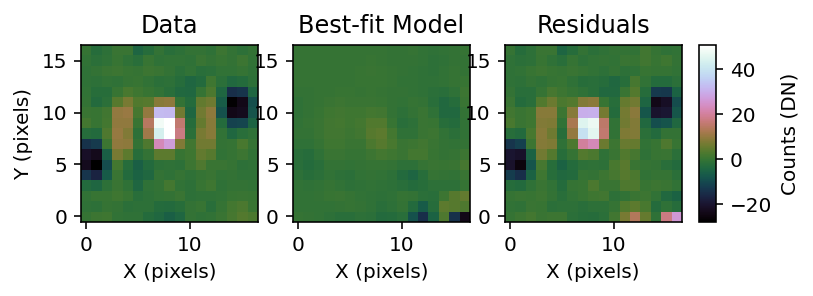

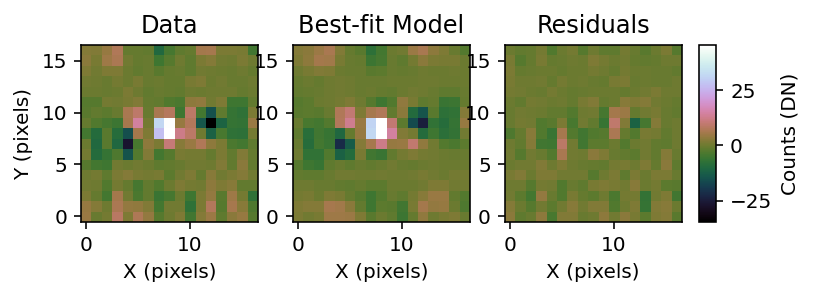

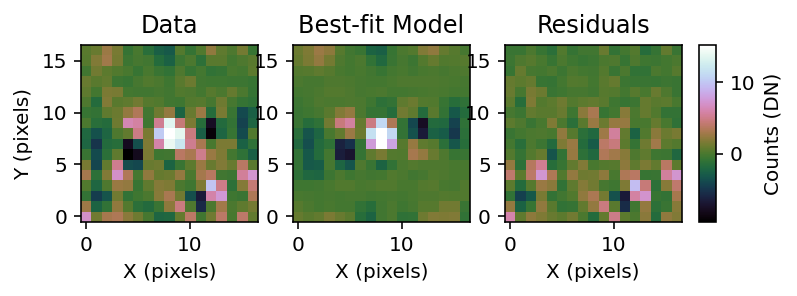

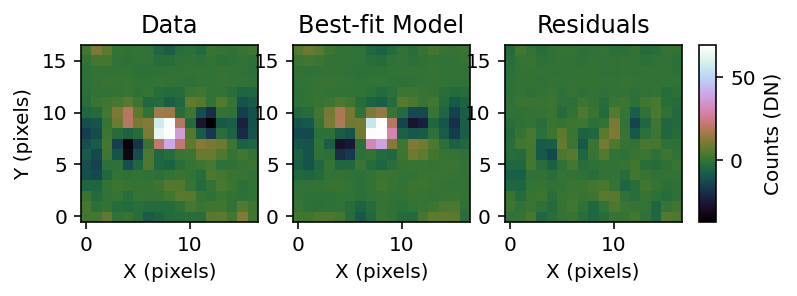

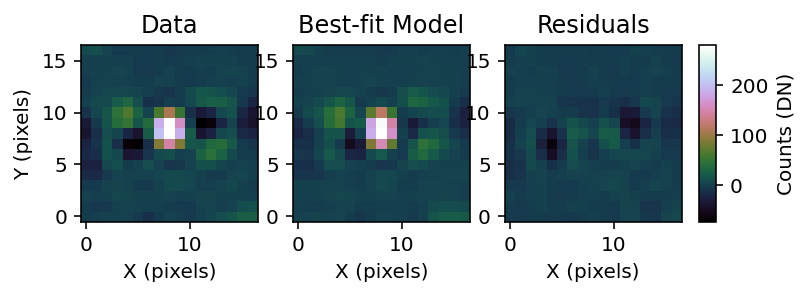

In [7]:
wavelength = [2.10,3.00, 3.35, 3.60, 4.10]

In [8]:
bw = [0.206, 0.315, 0.352, 0.370, 0.438]

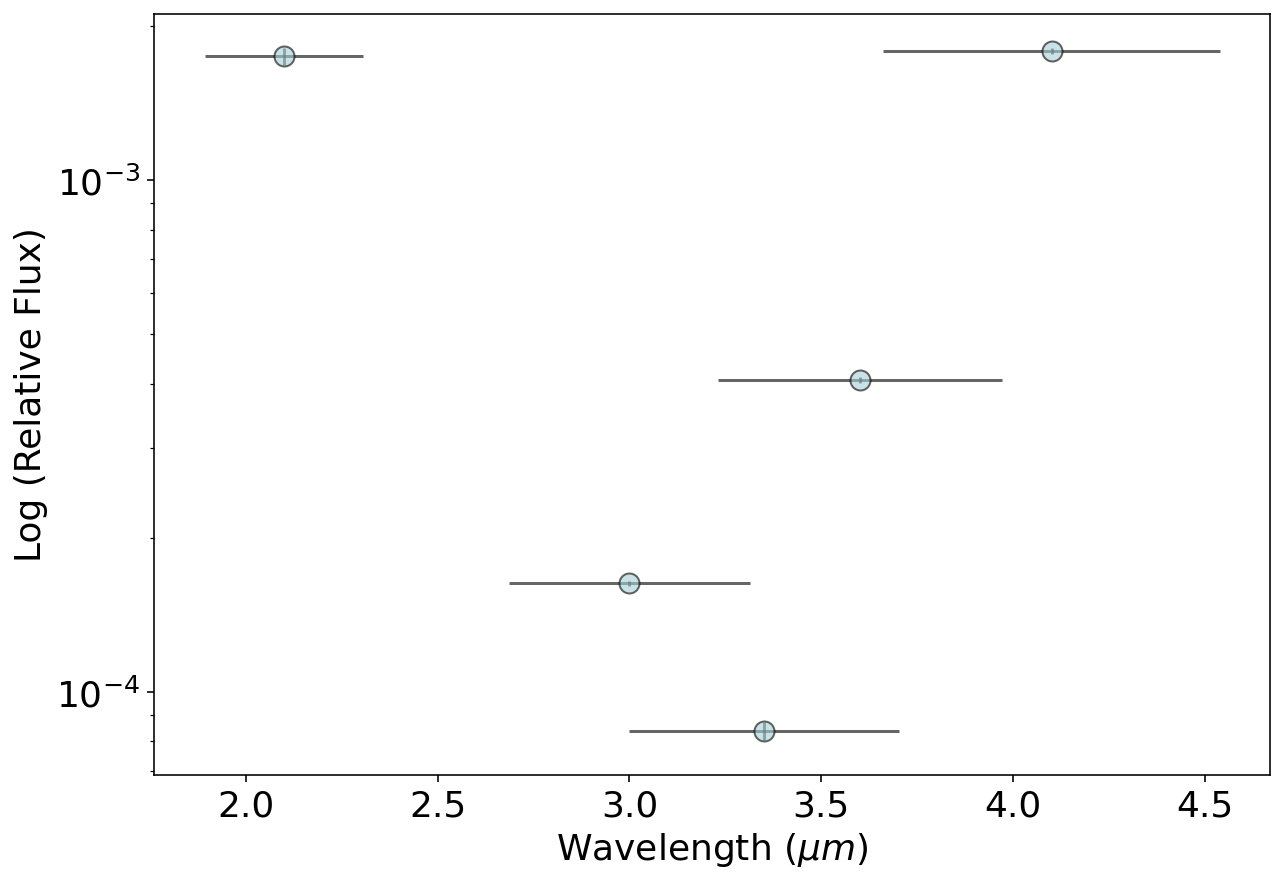

In [14]:
plt.figure(figsize=(10,7))
plt.rcParams.update({"font.size": 18})
plt.errorbar(wavelength, flux_vals, xerr=bw, yerr=flux_err, ecolor = 'black', color = "#A6CFD5", marker = 'o', ls = '', ms =10, alpha = 0.6, mec = 'black')
#plt.scatter(wavelength, flux_vals2, color = "#A1BF9C")
#plt.plot(wavelength, flux_vals2, color = "#A1BF9C")
#plt.ylim(-0.001, 0.01)
plt.yscale('log')
plt.xlabel('Wavelength ($\mu m$)')
plt.ylabel('Log (Relative Flux)')
plt.savefig('logcoronas_sed_outerp.png')

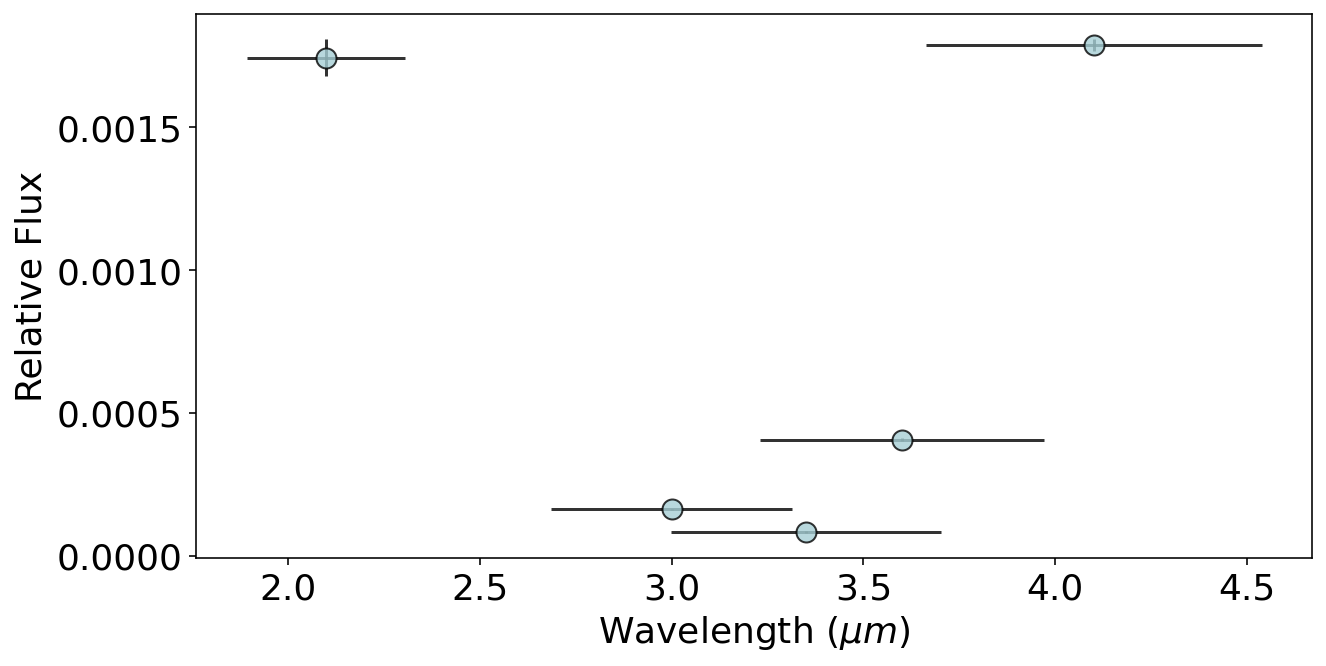

In [13]:
plt.figure(figsize=(10,5))
plt.rcParams.update({"font.size": 18})
plt.errorbar(wavelength, flux_vals, xerr=bw, yerr = flux_err, ecolor = 'black', color =  "#A6CFD5", marker = 'o', ls = '', ms =10, mec = 'black', alpha = .8)

plt.xlabel('Wavelength ($\mu m$)')
plt.ylabel('Relative Flux')
plt.savefig('coronas_sed_outerp.png')